In [20]:
import numpy as np
import pandas as pd
from Bio import Seq
from Bio.Seq import Seq
from gensim.models import Word2Vec
import joblib
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from common.env_config import config

In [9]:
train_df = pd.read_csv(config.TRAIN_DATA_CSV_FILE)
val_df = pd.read_csv(config.VAL_DATA_CSV_FILE).dropna()

X_train = train_df['sequence'].values
y_train = train_df['target'].values
X_val = val_df['sequence'].values
y_val = val_df['target'].values

print(f"Tổng số phage: {len(X_train) + len(X_val)}")
print(f"Số phage trong tập huấn luyện: {len(X_train)}")
print(f"Số phage trong tập kiểm tra: {len(X_val)}")
print(f"Số phage virulent trong tập huấn luyện: {len(X_train[y_train == 1])}")
print(f"Số phage temperate trong tập huấn luyện: {len(X_train[y_train == 0])}")
print(f"Số phage virulent trong tập kiểm tra: {len(X_val[y_val == 1])}")
print(f"Số phage temperate trong tập kiểm tra: {len(X_val[y_val == 0])}")

Tổng số phage: 2166
Số phage trong tập huấn luyện: 1733
Số phage trong tập kiểm tra: 433
Số phage virulent trong tập huấn luyện: 1184
Số phage temperate trong tập huấn luyện: 549
Số phage virulent trong tập kiểm tra: 296
Số phage temperate trong tập kiểm tra: 137


In [10]:
def reverse_complement_augmentation(sequences, labels):
    """Tạo dữ liệu bổ sung bằng cách đảo ngược bổ sung chuỗi DNA."""
    augmented_sequences = []
    augmented_labels = []

    for seq, label in zip(sequences, labels):
        # Thêm chuỗi gốc
        augmented_sequences.append(seq)
        augmented_labels.append(label)

        # Thêm chuỗi đảo ngược bổ sung
        reverse_comp = str(Seq(seq).reverse_complement())
        augmented_sequences.append(reverse_comp)
        augmented_labels.append(label)

    return np.array(augmented_sequences), np.array(augmented_labels)


# Áp dụng reverse complement augmentation
X_train_aug, y_train_aug = reverse_complement_augmentation(X_train, y_train)

print(f"Số phage trong tập huấn luyện sau augmentation: {len(X_train_aug)}")

Số phage trong tập huấn luyện sau augmentation: 3466


In [11]:
def generate_kmers(sequence, k=6):
    """Tạo k-mers từ một chuỗi DNA bằng cách dùng sliding window."""
    return [sequence[i:i + k] for i in range(len(sequence) - k + 1)]


def prepare_sequences_for_word2vec(sequences, k=6):
    """Chuẩn bị chuỗi cho Word2Vec bằng cách chuyển đổi thành các kmer."""
    corpus = []
    for seq in sequences:
        # Tạo k-mers và chỉ giữ những k-mer hợp lệ (chỉ chứa A, C, G, T)
        valid_kmers = [kmer for kmer in generate_kmers(seq, k)
                       if all(nucleotide in "ACGT" for nucleotide in kmer)]
        corpus.append(valid_kmers)
    return corpus


# Chuẩn bị dữ liệu cho Word2Vec
corpus = prepare_sequences_for_word2vec(X_train_aug, k=6)

# Huấn luyện mô hình Word2Vec với Skip-gram
word2vec_model = Word2Vec(
    sentences=corpus,
    vector_size=300,
    window=5,
    min_count=1,
    sample=1e-3,
    sg=1,  # Skip-gram model
    hs=0,  # Dùng negative sampling thay vì hierarchical softmax
    epochs=20,
    negative=5,
    workers=4,
    seed=42
)

# Lưu mô hình
word2vec_model.save("phage_word2vec_model.bin")

word2vec_model = Word2Vec.load("phage_word2vec_model.bin")


# Tạo vector cho mỗi chuỗi bằng cách tính trung bình các vector từ các k-mer
def sequence_to_vector(sequence, word2vec_model, k=6):
    """Chuyển đổi một chuỗi DNA thành vector đặc trưng sử dụng Word2Vec."""
    kmers = generate_kmers(sequence, k)
    valid_kmers = [kmer for kmer in kmers if kmer in word2vec_model.wv.key_to_index]

    if not valid_kmers:
        return np.zeros(word2vec_model.vector_size)

    # Tính trung bình các vector
    vectors = [word2vec_model.wv[kmer] for kmer in valid_kmers]
    return np.mean(vectors, axis=0)


# Chuyển đổi chuỗi thành vector đặc trưng
X_train_vectors = np.array([sequence_to_vector(seq, word2vec_model) for seq in X_train_aug])
X_test_vectors = np.array([sequence_to_vector(seq, word2vec_model) for seq in X_val])

print(f"Kích thước vector đặc trưng: {X_train_vectors.shape}")

Kích thước vector đặc trưng: (3466, 300)


Số lượng đặc trưng tối ưu: 257
Kích thước dữ liệu sau khi chọn đặc trưng: (3466, 257)


AttributeError: 'RFECV' object has no attribute 'grid_scores_'

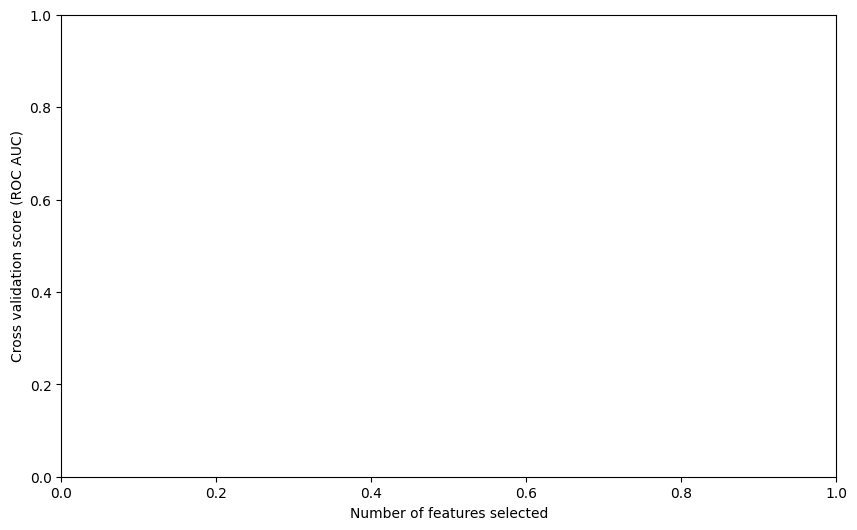

In [13]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Thiết lập SVM làm estimator cho RFECV
svm = SVC(kernel="linear", class_weight="balanced")

# Thiết lập RFECV
rfecv = RFECV(
    estimator=svm,
    step=1,
    cv=10,
    scoring="roc_auc",
    min_features_to_select=10,
    n_jobs=-1
)

# Thực hiện feature selection
rfecv.fit(X_train_vectors, y_train_aug)

# Lấy các đặc trưng được chọn
X_train_selected = rfecv.transform(X_train_vectors)
X_test_selected = rfecv.transform(X_test_vectors)

print(f"Số lượng đặc trưng tối ưu: {rfecv.n_features_}")
print(f"Kích thước dữ liệu sau khi chọn đặc trưng: {X_train_selected.shape}")

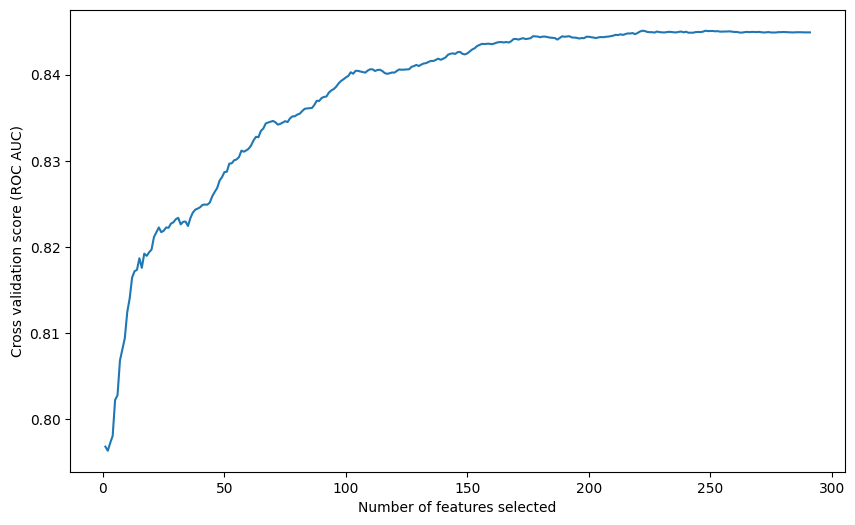

In [15]:
# Vẽ đồ thị số lượng đặc trưng vs. điểm số cross-validation
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (ROC AUC)")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.savefig("optimal_features.png")
plt.show()
plt.close()

In [17]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Thiết lập UMAP
reducer = umap.UMAP(
    n_components=3,
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)

# Áp dụng UMAP cho dữ liệu huấn luyện có chọn đặc trưng
X_umap = reducer.fit_transform(X_train_selected)

# Tạo DataFrame cho trực quan hóa
umap_df = pd.DataFrame({
    "UMAP1": X_umap[:, 0],
    "UMAP2": X_umap[:, 1],
    "UMAP3": X_umap[:, 2],
    "Lifecycle": y_train_aug
})

# Vẽ biểu đồ 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d")

virulent = umap_df[umap_df["Lifecycle"] == "virulent"]
temperate = umap_df[umap_df["Lifecycle"] == "temperate"]

ax.scatter(
    virulent["UMAP1"], virulent["UMAP2"], virulent["UMAP3"],
    c="blue", label="Virulent", alpha=0.7, s=30
)
ax.scatter(
    temperate["UMAP1"], temperate["UMAP2"], temperate["UMAP3"],
    c="red", label="Temperate", alpha=0.7, s=30
)

ax.set_title("3D UMAP Visualization of Bacteriophage Lifecycles")
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_zlabel("UMAP3")
ax.legend()

plt.savefig("phage_umap_3d.png", dpi=300, bbox_inches="tight")
plt.close()

# Kiểm tra dữ liệu thực tế trong cột Lifecycle
print(umap_df["Lifecycle"].unique())

# Sau đó điều chỉnh palette phù hợp
plt.figure(figsize=(12, 10))

# Nếu cột Lifecycle chứa 0 và 1 thay vì "virulent" và "temperate"
palette = {0: "blue", 1: "red"}  # Điều chỉnh nếu cần
sns.scatterplot(
    x="UMAP1", y="UMAP2",
    hue="Lifecycle",
    palette=palette,
    data=umap_df,
    alpha=0.7,
    s=30
)
plt.title("2D UMAP Visualization of Bacteriophage Lifecycles")
plt.savefig("phage_umap_2d.png", dpi=300, bbox_inches="tight")
plt.close()

C:\Users\Admin\miniconda3\envs\python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Admin\miniconda3\envs\python39\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[1 0]


In [21]:
def evaluate_model(model, X_train, y_train, X_test, y_val, model_name):
    """Đánh giá hiệu suất của mô hình và lưu lại kết quả."""
    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Dự đoán
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Tính các metric
    accuracy = (y_pred == y_val).mean()
    roc_auc = roc_auc_score(y_val, y_pred_proba) if y_pred_proba is not None else None

    # In kết quả
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
    print(classification_report(y_val, y_pred))

    # Lưu model
    joblib.dump(model, f"{model_name}_model.pkl")

    return {
        "model": model,
        "accuracy": accuracy,
        "roc_auc": roc_auc if roc_auc is not None else 0,
        "classification_report": classification_report(y_val, y_pred, output_dict=True)
    }

In [22]:
def evaluate_gaussian_nb():
    try:
        print("\n=== Evaluating GaussianNB ===")
        model = GaussianNB()

        # Định nghĩa không gian tham số
        param_space = {
            "var_smoothing": Real(1e-11, 1e-6, prior="log-uniform")
        }

        # Bayesian optimization
        bayes_search = BayesSearchCV(
            model,
            param_space,
            n_iter=30,
            cv=10,
            scoring="f1_weighted",
            n_jobs=-1,
            random_state=42
        )

        # Tìm tham số tối ưu
        bayes_search.fit(X_train_selected, y_train_aug)

        print(f"Best parameters: {bayes_search.best_params_}")
        print(f"Best cross-validation score: {bayes_search.best_score_:.4f}")

        # Đánh giá mô hình với tham số tối ưu
        best_model = bayes_search.best_estimator_
        return evaluate_model(best_model, X_train_selected, y_train_aug, X_test_selected, y_val, "GaussianNB")
    except Exception as e:
        print(f"Error evaluating GaussianNB: {str(e)}")
        return None

def evaluate_sgd_classifier():
    try:
        print("\n=== Evaluating SGDClassifier ===")
        model = SGDClassifier(random_state=42)

        # Định nghĩa không gian tham số
        param_space = {
            "alpha": Real(1e-6, 1e-1, prior="log-uniform"),
            "penalty": Categorical(["l1", "l2", "elasticnet"]),
            "loss": Categorical(["hinge", "log", "modified_huber"])
        }

        # Bayesian optimization
        bayes_search = BayesSearchCV(
            model,
            param_space,
            n_iter=30,
            cv=10,
            scoring="f1_weighted",
            n_jobs=-1,
            random_state=42
        )

        # Tìm tham số tối ưu
        bayes_search.fit(X_train_selected, y_train_aug)

        print(f"Best parameters: {bayes_search.best_params_}")
        print(f"Best cross-validation score: {bayes_search.best_score_:.4f}")

        # Đánh giá mô hình với tham số tối ưu
        best_model = bayes_search.best_estimator_
        return evaluate_model(best_model, X_train_selected, y_train_aug, X_test_selected, y_val, "SGDClassifier")
    except Exception as e:
        print(f"Error evaluating SGDClassifier: {str(e)}")
        return None

def evaluate_logistic_regression():
    try:
        print("\n=== Evaluating LogisticRegression ===")
        model = LogisticRegression(random_state=42)

        # Định nghĩa không gian tham số
        param_space = {
            "C": Real(0.1, 1000, prior="log-uniform"),
            "solver": Categorical(["liblinear", "saga"]),
            "penalty": Categorical(["l1", "l2"])
        }

        # Bayesian optimization
        bayes_search = BayesSearchCV(
            model,
            param_space,
            n_iter=30,
            cv=10,
            scoring="f1_weighted",
            n_jobs=-1,
            random_state=42
        )

        # Tìm tham số tối ưu
        bayes_search.fit(X_train_selected, y_train_aug)

        print(f"Best parameters: {bayes_search.best_params_}")
        print(f"Best cross-validation score: {bayes_search.best_score_:.4f}")

        # Đánh giá mô hình với tham số tối ưu
        best_model = bayes_search.best_estimator_
        return evaluate_model(best_model, X_train_selected, y_train_aug, X_test_selected, y_val, "LogisticRegression")
    except Exception as e:
        print(f"Error evaluating LogisticRegression: {str(e)}")
        return None

def evaluate_mlp_classifier():
    try:
        print("\n=== Evaluating MLPClassifier ===")
        model = MLPClassifier(random_state=42)

        # Định nghĩa không gian tham số
        param_space = {
            "hidden_layer_sizes": Categorical([(50,), (100,), (50, 50), (100, 50)]),
            "alpha": Real(1e-5, 1e-3, prior="log-uniform"),
            "learning_rate": Categorical(["constant", "adaptive"])
        }

        # Bayesian optimization
        bayes_search = BayesSearchCV(
            model,
            param_space,
            n_iter=30,
            cv=10,
            scoring="f1_weighted",
            n_jobs=-1,
            random_state=42
        )

        # Tìm tham số tối ưu
        bayes_search.fit(X_train_selected, y_train_aug)

        print(f"Best parameters: {bayes_search.best_params_}")
        print(f"Best cross-validation score: {bayes_search.best_score_:.4f}")

        # Đánh giá mô hình với tham số tối ưu
        best_model = bayes_search.best_estimator_
        return evaluate_model(best_model, X_train_selected, y_train_aug, X_test_selected, y_val, "MLPClassifier")
    except Exception as e:
        print(f"Error evaluating MLPClassifier: {str(e)}")
        return None

def evaluate_random_forest():
    try:
        print("\n=== Evaluating RandomForestClassifier ===")
        model = RandomForestClassifier(random_state=42)

        # Định nghĩa không gian tham số
        param_space = {
            "n_estimators": Integer(50, 300),
            "max_depth": Integer(5, 30),
            "min_samples_split": Integer(2, 10),
            "min_samples_leaf": Integer(1, 4)
        }

        # Bayesian optimization
        bayes_search = BayesSearchCV(
            model,
            param_space,
            n_iter=30,
            cv=10,
            scoring="f1_weighted",
            n_jobs=-1,
            random_state=42
        )

        # Tìm tham số tối ưu
        bayes_search.fit(X_train_selected, y_train_aug)

        print(f"Best parameters: {bayes_search.best_params_}")
        print(f"Best cross-validation score: {bayes_search.best_score_:.4f}")

        # Đánh giá mô hình với tham số tối ưu
        best_model = bayes_search.best_estimator_
        return evaluate_model(best_model, X_train_selected, y_train_aug, X_test_selected, y_val, "RandomForestClassifier")
    except Exception as e:
        print(f"Error evaluating RandomForestClassifier: {str(e)}")
        return None

def evaluate_svc():
    try:
        print("\n=== Evaluating SVC ===")
        model = SVC(probability=True, random_state=42)

        # Định nghĩa không gian tham số
        param_space = {
            "C": Real(1, 1500, prior="log-uniform"),
            "kernel": Categorical(["linear"]),  # Sử dụng kernel tuyến tính theo paper
            "gamma": Real(1e-4, 1e3, prior="log-uniform"),
            "class_weight": Categorical(["balanced"]),
            "cache_size": Integer(1000, 4000)
        }

        # Bayesian optimization
        bayes_search = BayesSearchCV(
            model,
            param_space,
            n_iter=30,
            cv=10,
            scoring="f1_weighted",
            n_jobs=-1,
            random_state=42
        )

        # Tìm tham số tối ưu
        bayes_search.fit(X_train_selected, y_train_aug)

        print(f"Best parameters: {bayes_search.best_params_}")
        print(f"Best cross-validation score: {bayes_search.best_score_:.4f}")

        # Đánh giá mô hình với tham số tối ưu
        best_model = bayes_search.best_estimator_
        return evaluate_model(best_model, X_train_selected, y_train_aug, X_test_selected, y_val, "SVC")
    except Exception as e:
        print(f"Error evaluating SVC: {str(e)}")
        return None

def evaluate_knn():
    try:
        print("\n=== Evaluating KNeighborsClassifier ===")
        model = KNeighborsClassifier()

        # Định nghĩa không gian tham số
        param_space = {
            "n_neighbors": Integer(3, 15),
            "weights": Categorical(["uniform", "distance"]),
            "p": Integer(1, 2)
        }

        # Bayesian optimization
        bayes_search = BayesSearchCV(
            model,
            param_space,
            n_iter=30,
            cv=10,
            scoring="f1_weighted",
            n_jobs=-1,
            random_state=42
        )

        # Tìm tham số tối ưu
        bayes_search.fit(X_train_selected, y_train_aug)

        print(f"Best parameters: {bayes_search.best_params_}")
        print(f"Best cross-validation score: {bayes_search.best_score_:.4f}")

        # Đánh giá mô hình với tham số tối ưu
        best_model = bayes_search.best_estimator_
        return evaluate_model(best_model, X_train_selected, y_train_aug, X_test_selected, y_val, "KNeighborsClassifier")
    except Exception as e:
        print(f"Error evaluating KNeighborsClassifier: {str(e)}")
        return None

def evaluate_gradient_boosting():
    try:
        print("\n=== Evaluating GradientBoostingClassifier ===")
        model = GradientBoostingClassifier(random_state=42)

        # Định nghĩa không gian tham số
        param_space = {
            "n_estimators": Integer(50, 300),
            "learning_rate": Real(0.01, 0.3),
            "max_depth": Integer(3, 10),
            "subsample": Real(0.5, 1.0)
        }

        # Bayesian optimization
        bayes_search = BayesSearchCV(
            model,
            param_space,
            n_iter=30,
            cv=10,
            scoring="f1_weighted",
            n_jobs=-1,
            random_state=42
        )

        # Tìm tham số tối ưu
        bayes_search.fit(X_train_selected, y_train_aug)

        print(f"Best parameters: {bayes_search.best_params_}")
        print(f"Best cross-validation score: {bayes_search.best_score_:.4f}")

        # Đánh giá mô hình với tham số tối ưu
        best_model = bayes_search.best_estimator_
        return evaluate_model(best_model, X_train_selected, y_train_aug, X_test_selected, y_val, "GradientBoostingClassifier")
    except Exception as e:
        print(f"Error evaluating GradientBoostingClassifier: {str(e)}")
        return None

def evaluate_xgboost():
    try:
        print("\n=== Evaluating XGBoost ===")
        model = xgb.XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric="logloss",
            tree_method="gpu_hist",  # Sử dụng GPU
            gpu_id=0,
            verbose=True
        )

        # Định nghĩa không gian tham số
        param_space = {
            "n_estimators": Integer(50, 300),
            "learning_rate": Real(0.01, 0.3),
            "max_depth": Integer(3, 10),
            "subsample": Real(0.5, 1.0),
            "colsample_bytree": Real(0.5, 1.0)
        }

        # Bayesian optimization
        bayes_search = BayesSearchCV(
            model,
            param_space,
            n_iter=30,
            cv=10,
            scoring="f1_weighted",
            n_jobs=-1,
            random_state=42
        )

        # Tìm tham số tối ưu
        bayes_search.fit(X_train_selected, y_train_aug)

        print(f"Best parameters: {bayes_search.best_params_}")
        print(f"Best cross-validation score: {bayes_search.best_score_:.4f}")

        # Đánh giá mô hình với tham số tối ưu
        best_model = bayes_search.best_estimator_
        return evaluate_model(best_model, X_train_selected, y_train_aug, X_test_selected, y_val, "XGBoost")
    except Exception as e:
        print(f"Error evaluating XGBoost: {str(e)}")
        return None

def evaluate_catboost():
    try:
        print("\n=== Evaluating CatBoostClassifier ===")
        model = CatBoostClassifier(
            random_state=42,
            verbose=True,
            task_type="GPU"  # Sử dụng GPU
        )

        # Định nghĩa không gian tham số
        param_space = {
            "iterations": Integer(50, 300),
            "learning_rate": Real(0.01, 0.3),
            "depth": Integer(4, 10)
        }

        # Bayesian optimization
        bayes_search = BayesSearchCV(
            model,
            param_space,
            n_iter=30,
            cv=10,
            scoring="f1_weighted",
            n_jobs=-1,
            random_state=42
        )

        # Tìm tham số tối ưu
        bayes_search.fit(X_train_selected, y_train_aug)

        print(f"Best parameters: {bayes_search.best_params_}")
        print(f"Best cross-validation score: {bayes_search.best_score_:.4f}")

        # Đánh giá mô hình với tham số tối ưu
        best_model = bayes_search.best_estimator_
        return evaluate_model(best_model, X_train_selected, y_train_aug, X_test_selected, y_val, "CatBoostClassifier")
    except Exception as e:
        print(f"Error evaluating CatBoostClassifier: {str(e)}")
        return None

def evaluate_lightgbm():
    try:
        print("\n=== Evaluating LightGBM ===")
        model = lgb.LGBMClassifier(
            random_state=42,
            device="gpu"  # Sử dụng GPU
        )

        # Định nghĩa không gian tham số
        param_space = {
            "n_estimators": Integer(50, 300),
            "learning_rate": Real(0.01, 0.3),
            "max_depth": Integer(3, 10),
            "subsample": Real(0.5, 1.0),
            "colsample_bytree": Real(0.5, 1.0)
        }

        # Bayesian optimization
        bayes_search = BayesSearchCV(
            model,
            param_space,
            n_iter=30,
            cv=10,
            scoring="f1_weighted",
            n_jobs=-1,
            random_state=42
        )

        # Tìm tham số tối ưu
        bayes_search.fit(X_train_selected, y_train_aug)

        print(f"Best parameters: {bayes_search.best_params_}")
        print(f"Best cross-validation score: {bayes_search.best_score_:.4f}")

        # Đánh giá mô hình với tham số tối ưu
        best_model = bayes_search.best_estimator_
        return evaluate_model(best_model, X_train_selected, y_train_aug, X_test_selected, y_val, "LightGBM")
    except Exception as e:
        print(f"Error evaluating LightGBM: {str(e)}")
        return None

In [ ]:
# Khởi tạo dictionary để lưu kết quả
results = {}

# Đánh giá GaussianNB
results["GaussianNB"] = evaluate_gaussian_nb()

# Đánh giá SGDClassifier
results["SGDClassifier"] = evaluate_sgd_classifier()

# Đánh giá LogisticRegression
results["LogisticRegression"] = evaluate_logistic_regression()

# Đánh giá MLPClassifier
results["MLPClassifier"] = evaluate_mlp_classifier()

# Đánh giá RandomForestClassifier
results["RandomForestClassifier"] = evaluate_random_forest()

# Đánh giá SVC
results["SVC"] = evaluate_svc()

# Đánh giá KNeighborsClassifier
results["KNeighborsClassifier"] = evaluate_knn()

# Đánh giá GradientBoostingClassifier
results["GradientBoostingClassifier"] = evaluate_gradient_boosting()

# Đánh giá XGBoost
results["XGBoost"] = evaluate_xgboost()

# Đánh giá CatBoostClassifier
results["CatBoostClassifier"] = evaluate_catboost()

# Đánh giá LightGBM
results["LightGBM"] = evaluate_lightgbm()

# In tổng hợp kết quả
print("\n=== Model Comparison ===")
for name, result in results.items():
    if result is not None:
        print(f"{name}: Accuracy = {result['accuracy']:.4f}, ROC AUC = {result['roc_auc']:.4f}")
    else:
        print(f"{name}: Failed to evaluate")

# Lưu kết quả
joblib.dump(results, "model_evaluation_results.pkl")


=== Evaluating GaussianNB ===


C:\Users\Admin\miniconda3\envs\python39\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.3207700962919092e-08] before, using random point [5.285869667940451e-10]
  warnings.warn(
C:\Users\Admin\miniconda3\envs\python39\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [4.841408179883096e-08] before, using random point [4.255853282447057e-10]
  warnings.warn(
C:\Users\Admin\miniconda3\envs\python39\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.3181431615277294e-10] before, using random point [8.748366834908634e-11]
  warnings.warn(
C:\Users\Admin\miniconda3\envs\python39\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [3.167405220163843e-11] before, using random point [4.8794110982418025e-09]
  warnings.warn(
C:\Users\Admin\miniconda3\envs\python39\l

Best parameters: OrderedDict([('var_smoothing', 1.1233621690895257e-09)])
Best cross-validation score: 0.6468

GaussianNB Results:
Accuracy: 0.6374
ROC AUC: 0.7405
              precision    recall  f1-score   support

           0       0.41      0.33      0.36       137
           1       0.72      0.78      0.75       296

    accuracy                           0.64       433
   macro avg       0.56      0.55      0.56       433
weighted avg       0.62      0.64      0.63       433


=== Evaluating SGDClassifier ===
Error evaluating SGDClassifier: The 'loss' parameter of SGDClassifier must be a str among {'squared_hinge', 'epsilon_insensitive', 'modified_huber', 'huber', 'hinge', 'log_loss', 'squared_epsilon_insensitive', 'squared_error', 'perceptron'}. Got 'log' instead.

=== Evaluating LogisticRegression ===


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import learning_curve
import seaborn as sns

# Lấy mô hình SVM tốt nhất từ kết quả
best_svm = results["SVC"]["model"]

# Vẽ learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_svm, X_train_selected, y_train_aug, cv=10,
    scoring="accuracy", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training score", color="blue", marker="o")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.15)
plt.plot(train_sizes, test_mean, label="Cross-validation score", color="red", marker="o")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="red", alpha=0.15)
plt.title("Learning Curve for SVM")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.grid(True)
plt.savefig("svm_learning_curve.png")
plt.close()

# Vẽ confusion matrix
y_pred = best_svm.predict(X_test_selected)
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Virulent", "Temperate"],
            yticklabels=["Virulent", "Temperate"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig("svm_confusion_matrix.png")
plt.close()

# Vẽ ROC curve
if hasattr(best_svm, "predict_proba"):
    y_scores = best_svm.predict_proba(X_test_selected)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.savefig("svm_roc_curve.png")
    plt.close()